# CS6140 Project - Detection Of Sarcasm In Text

## 1. Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
import re
import gensim
import gensim.downloader as api
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from sklearn.linear_model import LogisticRegression
import math

### 1.1 Download Glove

In [2]:
#Run if running notebook with vectors locally for first time. Files added to gitignore
#glove = api.load('glove-wiki-gigaword-300')
#glove.save('glovevectors.bin')

In [3]:
glove = KeyedVectors.load('glovevectors.bin')

In [4]:
# Run these if not up to date
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

### 1.2 Tokenize comments

In [5]:
data = pd.read_csv("train-balanced-sarcasm.csv")

In [6]:
data = data[['label', 'comment', 'subreddit', 'score', 'parent_comment']]

In [7]:
data.head(10)

,label,comment,subreddit,score,parent_comment
0,0,NC and NH.,politics,2,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,nba,-4,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",nfl,3,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",BlackPeopleTwitter,-8,deadass don't kill my buzz
4,0,I could use one of those tools.,MaddenUltimateTeam,6,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",AskReddit,0,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,AskReddit,1,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,FFBraveExvius,2,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",pcmasterrace,1,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,Lollapalooza,2,Probably count Kanye out Since the rest of his...


In [8]:
data.isna().sum()

label              0
comment           53
subreddit          0
score              0
parent_comment     0
dtype: int64

In [9]:
data = data.dropna(axis=0)

In [10]:
data.isna().sum()

label             0
comment           0
subreddit         0
score             0
parent_comment    0
dtype: int64

In [11]:
data['comment_tokens'] = data['comment']
data['comment_tokens'] = data['comment_tokens'].str.lower()
data['comment_tokens'] = data['comment_tokens'].str.replace('can\'t','can not',regex = True)
data['comment_tokens'] = data['comment_tokens'].str.replace('\'d',' would',regex = True)
data['comment_tokens'] = data['comment_tokens'].str.replace('wouldn\'t','would not',regex = True)
data['comment_tokens'] = data['comment_tokens'].str.replace('couldn\'t','could not',regex = True)
data['comment_tokens'] = data['comment_tokens'].str.replace('[^\w\s]','', regex = True)

In [12]:
data['parent_comment_tokens'] = data['parent_comment']
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.lower()
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.replace('can\'t','can not',regex = True)
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.replace('\'d',' would',regex = True)
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.replace('wouldn\'t','would not',regex = True)
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.replace('couldn\'t','could not',regex = True)
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.replace('[^\w\s]','', regex = True)

In [13]:
lemma = WordNetLemmatizer()
def apply_lemmatizer(sentence):
    return [lemma.lemmatize(token) for token in wordpunct_tokenize(sentence)]

In [14]:
data["comment_tokens"] = data.comment_tokens.apply(apply_lemmatizer)
data["parent_comment_tokens"] = data.parent_comment_tokens.apply(apply_lemmatizer)

In [15]:
data[["comment", "comment_tokens"]].head(10)

,comment,comment_tokens
0,NC and NH.,"[nc, and, nh]"
1,You do know west teams play against west teams...,"[you, do, know, west, team, play, against, wes..."
2,"They were underdogs earlier today, but since G...","[they, were, underdog, earlier, today, but, si..."
3,"This meme isn't funny none of the ""new york ni...","[this, meme, isnt, funny, none, of, the, new, ..."
4,I could use one of those tools.,"[i, could, use, one, of, those, tool]"
5,"I don't pay attention to her, but as long as s...","[i, dont, pay, attention, to, her, but, a, lon..."
6,Trick or treating in general is just weird...,"[trick, or, treating, in, general, is, just, w..."
7,Blade Mastery+Masamune or GTFO!,"[blade, masterymasamune, or, gtfo]"
8,"You don't have to, you have a good build, buy ...","[you, dont, have, to, you, have, a, good, buil..."
9,I would love to see him at lolla.,"[i, would, love, to, see, him, at, lolla]"


In [16]:
data['comment_tokens'].shape

(1010773,)

In [17]:
data[["parent_comment", "parent_comment_tokens"]].head(10)

,parent_comment,parent_comment_tokens
0,"Yeah, I get that argument. At this point, I'd ...","[yeah, i, get, that, argument, at, this, point..."
1,The blazers and Mavericks (The wests 5 and 6 s...,"[the, blazer, and, maverick, the, west, 5, and..."
2,They're favored to win.,"[theyre, favored, to, win]"
3,deadass don't kill my buzz,"[deadass, dont, kill, my, buzz]"
4,Yep can confirm I saw the tool they use for th...,"[yep, can, confirm, i, saw, the, tool, they, u..."
5,do you find ariana grande sexy ?,"[do, you, find, ariana, grande, sexy]"
6,What's your weird or unsettling Trick or Treat...,"[whats, your, weird, or, unsettling, trick, or..."
7,Probably Sephiroth. I refuse to taint his grea...,"[probably, sephiroth, i, refuse, to, taint, hi..."
8,What to upgrade? I have $500 to spend (mainly ...,"[what, to, upgrade, i, have, 500, to, spend, m..."
9,Probably count Kanye out Since the rest of his...,"[probably, count, kanye, out, since, the, rest..."


In [18]:
data['parent_comment_tokens'].shape

(1010773,)

In [19]:
X = data[['comment_tokens', 'parent_comment_tokens']]

In [20]:
X.head(10)

,comment_tokens,parent_comment_tokens
0,"[nc, and, nh]","[yeah, i, get, that, argument, at, this, point..."
1,"[you, do, know, west, team, play, against, wes...","[the, blazer, and, maverick, the, west, 5, and..."
2,"[they, were, underdog, earlier, today, but, si...","[theyre, favored, to, win]"
3,"[this, meme, isnt, funny, none, of, the, new, ...","[deadass, dont, kill, my, buzz]"
4,"[i, could, use, one, of, those, tool]","[yep, can, confirm, i, saw, the, tool, they, u..."
5,"[i, dont, pay, attention, to, her, but, a, lon...","[do, you, find, ariana, grande, sexy]"
6,"[trick, or, treating, in, general, is, just, w...","[whats, your, weird, or, unsettling, trick, or..."
7,"[blade, masterymasamune, or, gtfo]","[probably, sephiroth, i, refuse, to, taint, hi..."
8,"[you, dont, have, to, you, have, a, good, buil...","[what, to, upgrade, i, have, 500, to, spend, m..."
9,"[i, would, love, to, see, him, at, lolla]","[probably, count, kanye, out, since, the, rest..."


In [21]:
Y = data[['label']]

In [22]:
Y.tail(10)

,label
1010816,1
1010817,1
1010818,1
1010819,1
1010820,1
1010821,1
1010822,1
1010823,1
1010824,1
1010825,1


### 1.3 Split data into different sets

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size= 0.6)

In [24]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, train_size = 0.5)

In [25]:
X_train = X_train.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

In [26]:
y_train = y_train.reset_index(drop = True)
y_valid = y_val.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [27]:
X_train_s = X_train.copy()
X_val_s = X_val.copy()
X_test_s = X_test.copy()
y_train_s = y_train.copy()
y_val_s = y_val.copy()
y_test_s = y_test.copy()

In [28]:
X_train.head(10)

,comment_tokens,parent_comment_tokens
0,"[i, have, read, it, and, it, doesnt, say, that]","[the, first, amendment, protects, freedom, of,..."
1,"[narcissist, much]","[personalized, bathrobe, hey, guy, im, looking..."
2,"[apparently, people, are, getting, nightmare, ...","[freak, out, ad, did, i, miss, something]"
3,"[i, will, die, a, happy, man, probably, around...","[thanks, for, your, insight, a, is, that, othe..."
4,"[but, kung, fu, will, help, you, to, defend, y...","[a, an, asian, male, our, group, is, also, the..."
5,"[thats, cuz, the, u, let, craig, venter, run, ...","[til, that, despite, early, concern, the, huma..."
6,"[dont, steal, my, thunder, bro]","[the, fuck, are, you, talking, about, ram, hav..."
7,"[what, the, fuck]","[come, over, here, young, boy, and, grip, this..."
8,[lol],"[osama, bin, laden, gave, you, an, upvote, lol]"
9,"[thus, seems, like, a, lot, of, work, for, som...","[the, clearest, image, of, pluto, yet]"


In [29]:
len(X_train)

606463

In [30]:
data.shape

(1010773, 7)

### 1.4 Compute TFIDF

In [35]:
# Since comments are already preprocessed and tokenized,
# the vectorizer only needs to take tokens as they are.
tfidfVectorizer = TfidfVectorizer(analyzer=lambda tokens: tokens)
corpus = pd.concat([X_train['comment_tokens'], X_train['parent_comment_tokens']])
tfidfMatrix = tfidfVectorizer.fit_transform(corpus)
vocabulary = tfidfVectorizer.vocabulary_

In [36]:
tfidfMatrix.shape

(1212926, 284355)

In [37]:
# the tfidf matrix has 2021546 rows,
# where the 0 ~ 606462 rows represent original comments in the same order as those in dataset,
# and the 606463 ~ 1212926 rows represent parent comments in the same order as those in dataset;
# and the tfidf matrix has 395961 columns, each represents a word in the vocabulary.
tfidfMatrix

<1212926x284355 sparse matrix of type '<class 'numpy.float64'>'
	with 17840005 stored elements in Compressed Sparse Row format>

In [38]:
# By using the following dict, we can obtain the index of a given word for querying tfidf matrix.
vocabulary

{'i': 125746,
 'would': 277802,
 'not': 177790,
 'have': 117879,
 'known': 142057,
 'if': 126709,
 'he': 118302,
 'wa': 270364,
 '18': 4823,
 'you': 281918,
 'didnt': 77385,
 'tell': 248641,
 'me': 159132,
 'exactly': 91967,
 'the': 250200,
 'reason': 208134,
 'why': 275041,
 'area': 30935,
 'damage': 71333,
 'and': 27310,
 'supposedly': 243985,
 'life': 148434,
 'on': 182046,
 'hit': 121618,
 'cause': 55056,
 'lag': 144480,
 'is': 132477,
 'due': 83744,
 'to': 253679,
 'sheer': 226982,
 'number': 178980,
 'of': 180544,
 'extra': 93239,
 'computation': 63593,
 'server': 225468,
 'now': 178380,
 'ha': 115046,
 'perform': 190689,
 'human': 124553,
 'prison': 199714,
 'etc': 90739,
 'kulcha': 143550,
 'forgot': 101022,
 'add': 21606,
 'this': 251375,
 'legendary': 146870,
 'kairoplays': 138122,
 'they': 250974,
 'are': 30934,
 'geez': 107076,
 'it': 133070,
 'just': 137485,
 'a': 19202,
 'joke': 136399,
 'that': 249955,
 'black': 43575,
 'people': 190341,
 'ruin': 217748,
 'everything': 9

Once we have learned word vectors, to compute the sentence vector of a comment,
first fetch the corresponding row from the tfidf matrix (if it is the i-th original comment, then
it is the i-th row; if it is the i-th parent comment, then it is the (1010773 + i)-th row),
second for each word in the comment find its corresponding tfidf value from the row,
third compute the average of the word vectors weighted by corresponding tfidf values.

In [39]:
tfidfMatrix.shape

(1212926, 284355)

In [40]:
tfidfMatrix[0,249920]

0.0

In [41]:
vocabulary['thats']

250061

In [42]:
tfidfMatrixtest = tfidfVectorizer.transform(pd.concat([X_test['comment_tokens'], X_test['parent_comment_tokens']]))
tfidfMatrixvalid = tfidfVectorizer.transform(pd.concat([X_val['comment_tokens'], X_val['parent_comment_tokens']]))

In [43]:
tfidfMatrixtest.shape

(404310, 284355)

In [44]:
X_test.head(10)

,comment_tokens,parent_comment_tokens
0,[foundation],"[awesome, restaurant, on, main, st, downtowner..."
1,"[soapy, water]","[you, can, spray, it, with, water, and, look, ..."
2,"[to, be, fair, though, faze, do, still, have, ...","[nv, going, to, hold, onto, this, w, like, faz..."
3,"[oh, fuck]","[michy, batshuayi, goal, v, watford, 11]"
4,"[oh, the, joy, of, being, a, christian, nation]","[even, more, so, american, want, revenge, amp,..."
5,"[keep, them, donation, coming, he, can, win]","[sander, outpaces, clinton, in, fundraising, f..."
6,"[itt, unnecessary, politics]","[mean, spirited]"
7,"[i, needed, a, trigger, warning, im, having, t...","[i, like, you, the, right, hand, wa, lost, sav..."
8,"[they, are, doing, awfully, well, for, the, bu...","[logic, and, common, sense, do, not, prevail, ..."
9,"[you, are, a, genius]","[yeah, the, reality, version, go, like, this, ..."


In [45]:
vocabulary['for']

100687

In [46]:
tfidfMatrixtest[0, 100573]

0.0

### 1.5 Compute sentence vectors

In [47]:
def generate_dataset(X, tfidfmat):
    comment_featurevec = []
    parent_featurevec = []
    
    for index, sample in X.iterrows():
        
        comment_vec = np.zeros(300)
        parent_comment_vec = np.zeros(300)
        comment_tokens = sample['comment_tokens']
        parent_comment_tokens = sample['parent_comment_tokens']
        counter1 = 0
        
        for token in comment_tokens:
            
            if token in glove and token in vocabulary:
                counter1 += 1
                comment_vec += tfidfmat[index, vocabulary[token]] * glove[token]
        
        counter2 = 0
        for token in parent_comment_tokens:
            
            if token in glove and token in vocabulary:
                counter2 += 1 
                parent_comment_vec += tfidfmat[index+len(X), vocabulary[token]] * glove[token]
        
        if counter1 != 0:
            comment_featurevec.append(comment_vec/counter1)
        else:
            comment_featurevec.append(comment_vec)
        
        if counter2 != 0:
            parent_featurevec.append(parent_comment_vec/counter2)
        else:
            parent_featurevec.append(parent_comment_vec)
            
        
    #print(len(comment_featurevec))
    X['comment_weighted_vec'] = comment_featurevec
    X['parent_weighted_vec'] = parent_featurevec
    new_df = pd.DataFrame()
        
    return X
    
    


In [48]:
X_train = generate_dataset(X_train, tfidfMatrix)

In [49]:
X_val = generate_dataset(X_val, tfidfMatrixvalid)

In [50]:
X_test = generate_dataset(X_test, tfidfMatrixtest)

In [51]:
X_train = X_train[['comment_weighted_vec', 'parent_weighted_vec']]
X_val = X_val[['comment_weighted_vec', 'parent_weighted_vec']]
X_test = X_test[['comment_weighted_vec', 'parent_weighted_vec']]

In [52]:
def featurize(dataset):
    x = pd.DataFrame(dataset['parent_weighted_vec'].tolist(), columns = [i for i in range(300)])
    y = pd.DataFrame(dataset['comment_weighted_vec'].tolist(), columns = [i for i in range(300, 600)])
    return pd.concat([x, y], axis = 1)

In [53]:
X_train = featurize(X_train)
X_val = featurize(X_val)
X_test = featurize(X_test)

### 1.6 Compute Glove sequence for LSTM (deleted)

## 2. Models

### 2.1 Logistic Regression

In [54]:
clf = LogisticRegression(max_iter = 500).fit(X_train, y_train.values.ravel())

In [55]:
clf.score(X_test, y_test)

0.5957408918898864

In [56]:
clf.score(X_val, y_val)

0.5952066483638792

In [57]:
clf.predict(X_test.iloc[2].values.reshape(1,-1))

array([0])

### 2.2 Feed Forward Neural Net

In [53]:
torch.cuda.is_available()

False

In [54]:
def get_default_device():
    """Picking GPU if available or else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()

In [55]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [79]:
x_tr = torch.tensor(X_train.iloc[:,0:600].values, dtype= torch.float32)
x_val = torch.tensor(X_val.iloc[:,0:600].values, dtype= torch.float32)
x_test = torch.tensor(X_test.iloc[:,0:600].values,dtype= torch.float32)
y_tr = torch.tensor(list(y_train['label']), dtype= torch.long)
y_vali = torch.tensor(list(y_val['label']), dtype= torch.long)
y_tst = torch.tensor(list(y_test['label']), dtype= torch.long)

In [82]:
x_tr.to(device)

tensor([[-0.0811, -0.0394, -0.0260,  ..., -0.1191, -0.0266,  0.0586],
        [-0.0340,  0.0345,  0.0137,  ..., -0.0060, -0.0006, -0.0163],
        [-0.0231,  0.0317, -0.0088,  ..., -0.0011, -0.0802,  0.1426],
        ...,
        [ 0.3366,  0.5286, -0.2200,  ..., -0.0442,  0.0252,  0.1101],
        [-0.0176,  0.0424, -0.0470,  ...,  0.1297,  0.2087, -0.0245],
        [-0.0102,  0.0293,  0.0221,  ..., -0.1184,  0.0442,  0.0703]])

In [83]:
x_val.to(device)
x_test.to(device)
y_tr.to(device)
y_vali.to(device)
y_tst.to(device)

tensor([1, 0, 1,  ..., 1, 1, 1])

In [84]:
class XY(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y
  def __len__(self):
    return len(self.y)
  def __getitem__(self, i):
    return self.x[i], self.y[i]

In [85]:
trainset = XY(x_tr, y_tr)
valset = XY(x_val, y_vali)
testset = XY(x_test, y_tst)

In [86]:
input_dim = 600
hidden_dim = 256
num_layers = 2
output_dim = 2
num_epochs = 100
batch_size = 128

In [87]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size = batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle=True)

In [88]:
class FFNN(nn.Module):
    def __init__(self, layer_num, input_dim, hidden_dim, output_dim):
      super(FFNN, self).__init__()
      self.layers = []
      for i in range(layer_num):
        self.layers.append(nn.Linear(input_dim if i == 0 else hidden_dim, hidden_dim))
        self.layers.append(nn.ReLU())
      self.layers.append(nn.Linear(input_dim if layer_num == 0 else hidden_dim, output_dim))

      self.layers = nn.ModuleList(self.layers)
    
    def forward(self, x):
        for layer in self.layers:
          x = layer(x)
        return x

In [89]:
model = FFNN(num_layers, input_dim, hidden_dim, output_dim).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [90]:
train_losses = []
val_losses = []
val_loss_min = math.inf
for epoch in range(num_epochs):
    train_loss = 0
    val_loss = 0
    
    model.train()
    for data, target in trainloader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      loss = loss_fn(output, target)  
      train_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    model.eval()
    for data, target in valloader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      loss = loss_fn(output, target)
      val_loss += loss.item()
    
    train_losses.append(train_loss/len(trainloader))
    val_losses.append(val_loss/len(valloader))

    if val_loss <= val_loss_min:
      torch.save(model.state_dict(), 'model.pt')
      val_loss_min = val_loss
    if (epoch + 1) % 5 == 0:
      print("Epoch completed: " + str(epoch+1) +
            f"\n\tTraining Loss: {train_losses[epoch]:.3f}" + 
            f"\n\tValidation Loss: {val_losses[epoch]:.3f}\n")

Epoch completed: 5
	Training Loss: 0.567
	Validation Loss: 0.617

Epoch completed: 10
	Training Loss: 0.512
	Validation Loss: 0.664

Epoch completed: 15
	Training Loss: 0.467
	Validation Loss: 0.738

Epoch completed: 20
	Training Loss: 0.432
	Validation Loss: 0.834

Epoch completed: 25
	Training Loss: 0.405
	Validation Loss: 0.925

Epoch completed: 30
	Training Loss: 0.382
	Validation Loss: 1.022

Epoch completed: 35
	Training Loss: 0.364
	Validation Loss: 1.122

Epoch completed: 40
	Training Loss: 0.349
	Validation Loss: 1.224

Epoch completed: 45
	Training Loss: 0.335
	Validation Loss: 1.307

Epoch completed: 50
	Training Loss: 0.324
	Validation Loss: 1.399

Epoch completed: 55
	Training Loss: 0.313
	Validation Loss: 1.478

Epoch completed: 60
	Training Loss: 0.304
	Validation Loss: 1.567

Epoch completed: 65
	Training Loss: 0.296
	Validation Loss: 1.634

Epoch completed: 70
	Training Loss: 0.288
	Validation Loss: 1.724

Epoch completed: 75
	Training Loss: 0.281
	Validation Loss: 1.7

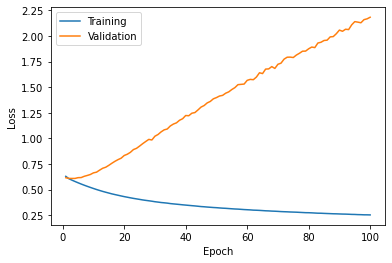

In [92]:
plt.plot(list(range(1,len(train_losses) + 1)), train_losses, label = "Training")
plt.plot(list(range(1,len(val_losses) +1)), val_losses, label = "Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [93]:
from sklearn.metrics import classification_report
preds = []
labels = torch.tensor(list(y_val['label'].values))
model = FFNN(num_layers, input_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load('model.pt'))
with torch.no_grad():
    for index, row in X_val.iterrows():
        output = model(torch.Tensor(row))
        preds.append(torch.argmax(output, dim=0))

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.64      0.74      0.68    100973
           1       0.69      0.58      0.63    101182

    accuracy                           0.66    202155
   macro avg       0.66      0.66      0.66    202155
weighted avg       0.66      0.66      0.66    202155



In [94]:
from sklearn.metrics import classification_report
preds = []
labels = torch.tensor(list(y_test['label'].values))
model = FFNN(num_layers, input_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load('model.pt'))
with torch.no_grad():
    for index, row in X_test.iterrows():
        output = model(torch.Tensor(row))
        preds.append(torch.argmax(output, dim=0))

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.64      0.74      0.69    101032
           1       0.69      0.59      0.63    101123

    accuracy                           0.66    202155
   macro avg       0.67      0.66      0.66    202155
weighted avg       0.67      0.66      0.66    202155



### 2.3 LSTM

In [28]:
class Indices(Dataset):
    def __init__(self, dataset):
        self.data = dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return i

In [29]:
train_seq_idx_set = Indices(X_train_s)
val_seq_idx_set = Indices(X_val_s)
test_seq_idx_set = Indices(X_test_s)

In [30]:
len(train_seq_idx_set)

606463

In [31]:
train_seq_idx_set[500000]

500000

In [32]:
class SarcasmLSTM(nn.Module):
    def __init__(self, input_size=300, lstm_hidden_size=256, lstm_num_layers=1, linear_hidden_size=256, linear_num_layers=1, output_size=2):
        super(SarcasmLSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(glove.vectors)
        self.comment_lstm = nn.LSTM(input_size=input_size, hidden_size=lstm_hidden_size, num_layers=lstm_num_layers, batch_first=True)
        self.parent_comment_lstm = nn.LSTM(input_size=input_size, hidden_size=lstm_hidden_size, num_layers=lstm_num_layers, batch_first=True)
        self.linear = nn.Sequential()
        for i in range(linear_num_layers):
            self.linear.append(nn.Linear(lstm_hidden_size * 2 if i == 0 else linear_hidden_size, linear_hidden_size))
            self.linear.append(nn.ReLU())
        self.linear.append(nn.Linear(lstm_hidden_size * 2 if linear_num_layers == 0 else linear_hidden_size, output_size))

    def forward(self, comments, parent_comments):
        packed_comments = nn.utils.rnn.pack_sequence(comments, enforce_sorted=False)
        packed_parent_comments = nn.utils.rnn.pack_sequence(parent_comments, enforce_sorted=False)
        packed_comments_encoding, _ = self.comment_lstm(packed_comments)
        packed_parent_comments_encoding, _ = self.parent_comment_lstm(packed_parent_comments)
        comments_encoding, comments_lengths = nn.utils.rnn.pad_packed_sequence(packed_comments_encoding, batch_first=True)
        parent_comments_encoding, parent_comments_lengths = nn.utils.rnn.pad_packed_sequence(packed_parent_comments_encoding, batch_first=True)
        comments_encoding = comments_encoding[range(comments_encoding.shape[0]), comments_lengths - 1]
        parent_comments_encoding = parent_comments_encoding[range(parent_comments_encoding.shape[0]), parent_comments_lengths - 1]
        encoding = torch.concat((comments_encoding, parent_comments_encoding), 1)
        logit = self.linear(encoding)
        return logit

In [81]:
class SarcasmLSTMDetector:
    def __init__(self, lstm_model):
        self.model = lstm_model
        print(self.model)

    @staticmethod
    def convert(array):
        return torch.from_numpy(array)

    def fit(self, train_indices, train_seq, train_labels, val_indices, val_seq, val_labels, lr=0.001, epochs=100):
        train_losses = []
        val_losses = []
        val_loss_min = math.inf

        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

        for epoch in range(epochs):
            train_loss = 0
            val_loss = 0

            self.model.train()
            for indices in train_indices:
                mini_batch = train_seq.iloc[indices]
                comments = mini_batch['comment_seq']
                comments = comments.map(SarcasmLSTMDetector.convert)
                parent_comments = mini_batch['parent_comment_seq']
                parent_comments = parent_comments.map(SarcasmLSTMDetector.convert)
                labels = torch.from_numpy(train_labels.iloc[indices].to_numpy().reshape(-1))
                predictions = self.model(comments, parent_comments)
                loss = loss_fn(predictions, labels)
                train_loss += loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            self.model.eval()
            for indices in val_indices:
                mini_batch = val_seq.iloc[indices]
                comments = mini_batch['comment_seq']
                comments = comments.map(SarcasmLSTMDetector.convert)
                parent_comments = mini_batch['parent_comment_seq']
                parent_comments = parent_comments.map(SarcasmLSTMDetector.convert)
                labels = torch.from_numpy(val_labels.iloc[indices].to_numpy().reshape(-1))
                predictions = self.model(comments, parent_comments)
                loss = loss_fn(predictions, labels)
                val_loss += loss.item()

            train_losses.append(train_loss/len(trainloader))
            val_losses.append(val_loss/len(valloader))
            if val_loss <= val_loss_min:
                torch.save(model.state_dict(), 'lstm_model.pt')
                val_loss_min = val_loss
            if (epoch + 1) % 5 == 0:
                print("Epoch completed: " + str(epoch+1) +
                      f"\n\tTraining Loss: {train_losses[epoch]:.3f}" +
                      f"\n\tValidation Loss: {val_losses[epoch]:.3f}\n")

        return train_losses, val_losses

    def eval(self, test_indices, test_seq, test_labels):
        test_loss = 0
        loss_fn = nn.CrossEntropyLoss()
        self.model.eval()
        for indices in test_indices:
            mini_batch = test_seq.iloc[indices]
            comments = mini_batch['comment_seq']
            comments = comments.map(SarcasmLSTMDetector.convert)
            parent_comments = mini_batch['parent_comment_seq']
            parent_comments = parent_comments.map(SarcasmLSTMDetector.convert)
            labels = torch.from_numpy(test_labels.iloc[indices].to_numpy().reshape(-1))
            predictions = self.model(comments, parent_comments)
            loss = loss_fn(predictions, labels)
            test_loss += loss.item()
        print(f"Test Loss: {test_loss:.3f}")
        return test_loss

In [82]:
lstm_batch_size = 64
train_seq_idx_loader = torch.utils.data.DataLoader(train_seq_idx_set, lstm_batch_size, True)
val_seq_idx_loader = torch.utils.data.DataLoader(val_seq_idx_set, lstm_batch_size, True)
test_seq_idx_loader = torch.utils.data.DataLoader(test_seq_idx_set, lstm_batch_size, True)

In [83]:
baseline_model = SarcasmLSTM()
baseline_detector = SarcasmLSTMDetector(baseline_model)

SarcasmLSTM(
  (comment_lstm): LSTM(300, 256, batch_first=True)
  (parent_comment_lstm): LSTM(300, 256, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
)


In [204]:
lstm_train_losses, lstm_val_losses = baseline_detector.fit(train_seq_idx_loader, train_seq, train_labels, val_seq_idx_loader, val_seq, val_labels)

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [84]:
test_labels.iloc[[2,4,5,7]].to_numpy().reshape(-1)

array([0, 0, 1, 1])

In [88]:
val_seq.iloc[[2,4,5,7]]['parent_comment_seq']

2    [[-0.1447100043296814, 0.2703399956226349, -0....
4    [[-0.029205, 0.35396, -0.69416, 0.31261, 0.155...
5    [[-0.41355, 0.076012, 0.099178, -0.01195, 0.01...
7    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: parent_comment_seq, dtype: object